In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import geopandas as gdp
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
host_table_with_trip_id = pd.read_csv('/content/drive/MyDrive/v2x_data/V2X_V1/host_table_with_trip_id.csv')

In [30]:
summary_table_with_trip_id = pd.read_csv('/content/drive/MyDrive/v2x_data/V2X_V1/summary_table_with_trip_id.csv')

In [4]:
# we have multiple rows where the data was not found in summary (sampling issue)
#so we need to drop the tables with trip_uuid = 0

host_table_with_trip_id_updated = host_table_with_trip_id[host_table_with_trip_id['trip_uuid']!=0]

In [ ]:
def custom_mean(series):
    return series.mean()

def custom_sum(series):
    return series.sum()

def count_greater_than_one(series):
    return (series >= 1).sum()

def mean_absolute(series):
    return series.abs().mean()

# Group by 'trip_uuid' and apply custom aggregation functions
aggregated_host_on_trip = host_table_with_trip_id_updated.groupby('trip_uuid').agg({
    'absstatus': custom_sum,   # status of abs
    'brakestatus': custom_sum,    # number of times brakes engaged
    'gpsspeed': custom_mean,  # average gps speed
    'speed': custom_mean,  # average speed
    'longaccel' : mean_absolute, # aboslute mean of acceleration
    'stabilitycontrolstatus' : custom_sum,
    'steerangle' : mean_absolute,
    'throttlepospct' : custom_mean,
    'turnsignal' : count_greater_than_one,
    'yawrate' : mean_absolute,
    'device' : first

}).reset_index()

aggregated_host_on_trip['device'] = host_table_with_trip_id_updated


In [7]:
aggregated_host_on_trip.head()

,trip_uuid,absstatus,brakestatus,gpsspeed,speed,longaccel,stabilitycontrolstatus,steerangle,throttlepospct,turnsignal,yawrate
0,0,3.0,26485.0,22.507369,20.194923,0.324766,0.0,15.495950,4.708169,11693,1.452265
1,002009ad-17f7-41d0-a95d-79f5e189679a,0.0,120.0,21.543370,21.696048,0.000000,0.0,0.000000,38.084538,85,0.000000
2,004efcf0-a40e-4e94-b96d-322973476dbb,0.0,1628.0,22.821166,21.752625,0.310249,0.0,11.893145,6.401485,618,0.930467
3,00559627-9d10-4d03-aa19-6dd0c560b333,0.0,177.0,14.257832,14.461755,0.395826,0.0,13.724387,0.000000,175,1.889543
4,00b2691c-3b6e-48c5-a3ae-fcde13d94028,0.0,79.0,8.420609,9.529739,0.710086,0.0,35.654588,6.730392,35,3.955280


In [10]:
aggregated_host_on_trip = aggregated_host_on_trip.drop(aggregated_host_on_trip.index[0])

In [17]:
aggregated_host_on_trip.head()

trip_uuid                 002009ad-17f7-41d0-a95d-79f5e189679a004efcf0-a...
absstatus                                                               0.0
brakestatus                                                          2131.0
gpsspeed                                                          89.570097
speed                                                             89.966871
longaccel                                                          1.851457
stabilitycontrolstatus                                                  0.0
steerangle                                                         61.27212
throttlepospct                                                    51.216415
turnsignal                                                              913
yawrate                                                            8.809804
dtype: object

In [18]:
aggregated_host_on_trip.isna().sum()

trip_uuid                  0
absstatus                  0
brakestatus                0
gpsspeed                   0
speed                      0
longaccel                  0
stabilitycontrolstatus     0
steerangle                 0
throttlepospct            19
turnsignal                 0
yawrate                    0
dtype: int64

In [19]:
aggregated_host_on_trip.fillna(0,inplace=True)

In [23]:
aggregated_host_on_trip.dtypes

trip_uuid                  object
absstatus                 float64
brakestatus               float64
gpsspeed                  float64
speed                     float64
longaccel                 float64
stabilitycontrolstatus    float64
steerangle                float64
throttlepospct            float64
turnsignal                  int64
yawrate                   float64
dtype: object

In [25]:
aggregated_host_on_trip.columns

Index(['trip_uuid', 'absstatus', 'brakestatus', 'gpsspeed', 'speed', 'longaccel',
       'stabilitycontrolstatus', 'steerangle', 'throttlepospct', 'turnsignal', 'yawrate'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


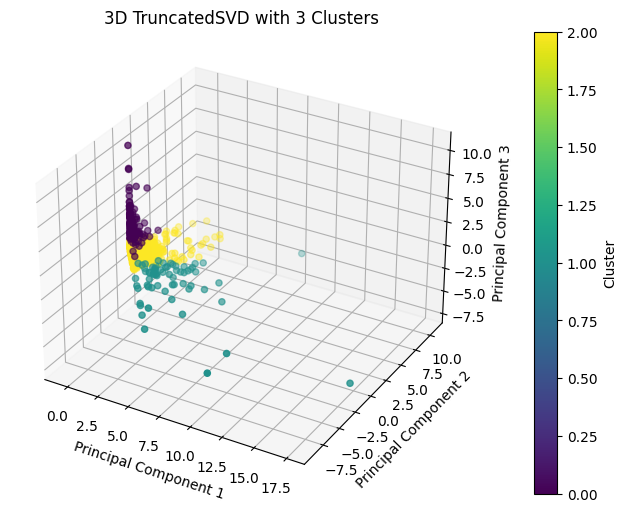

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

svd = TruncatedSVD(n_components=3)
reduced_features = svd.fit_transform(aggregated_host_on_trip[['absstatus', 'brakestatus', 'gpsspeed', 'speed', 'longaccel',
       'stabilitycontrolstatus', 'steerangle', 'throttlepospct', 'turnsignal', 'yawrate']])

scaler = StandardScaler()
reduced_features_scaled = scaler.fit_transform(reduced_features)

for i in range(3,4):
  num_clusters = i
  kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)
  aggregated_host_on_trip['Cluster'] = kmeans.fit_predict(reduced_features_scaled)

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(reduced_features_scaled[:, 0], reduced_features_scaled[:, 1], reduced_features_scaled[:, 2],
                      c=aggregated_host_on_trip['Cluster'], cmap='viridis', marker='o')

  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_zlabel('Principal Component 3')
  ax.set_title(f'3D TruncatedSVD with {num_clusters} Clusters')

  fig.colorbar(scatter, ax=ax, label='Cluster',pad=0.1)

  plt.show()

  df_clustered = pd.DataFrame(reduced_features_scaled, columns=['PC1', 'PC2', 'PC3'])
  df_clustered['Cluster'] = aggregated_host_on_trip['Cluster']
  # print(df_clustered.head())


  fig = px.scatter_3d(
      aggregated_host_on_trip, x=reduced_features_scaled[:, 0], y=reduced_features_scaled[:, 1], z=reduced_features_scaled[:, 2],
      color='Cluster',
      labels={'x': 'Principal Component 1', 'y': 'Principal Component 2', 'z': 'Principal Component 3'},
      title=f'Interactive 3D Plot with 5 Clusters'
  )
  fig.update_layout(width=1000, height=1000)
  fig.show()
  fig.write_html("five_cluster.html")


In [31]:
#lets merge the summary table with aggregated data

merged_host_summary = pd.merge(aggregated_host_on_trip, summary_table_with_trip_id, on='trip_uuid', how='left')

In [32]:
merged_host_summary.head()

,trip_uuid,absstatus,brakestatus,gpsspeed,speed,longaccel,stabilitycontrolstatus,steerangle,throttlepospct,turnsignal,yawrate,Cluster,Unnamed: 0,configsversionstring,configversion,deltamediaversionstring,device,endlatitude,endlocaltime,endlongitude,endodometer,filedate,filetimeutc,firmwareversionstring,fullmediaversionstring,key,numbsmtx,numcanoutages,numgnssoutages,numinforms,numintersectionencounters,numnormalbsmrx,numshadowbsmrx,numspatrx,numwarnings,pluginsversionstring,startlatitude,startlocaltime,startlongitude,startodometer,storageused,swversionmaj,swversionmin,totalstorageondevice,utctime,uuid
0,002009ad-17f7-41d0-a95d-79f5e189679a,0.0,120.0,21.543370,21.696048,0.000000,0.0,0.000000,38.084538,85,0.000000,2,1277,NaN,0,NaN,102013,40.228497,64676709.0,-83.312096,NaN,20200616.0,174622.0,NaN,NaN,eyJ1dWlkIjoiN2VkZmI4ZGNlYWEzYzQ5YWU3MzkyZTVhZT...,6864.0,13.0,0.0,0.0,0.0,0.0,0.0,3802.0,0.0,NaN,40.254187,64225365.0,-83.372305,0.0,NaN,2.0,2.0,NaN,1.592330e+12,7edfb8dceaa3c49ae7392e5ae86e0f84
1,004efcf0-a40e-4e94-b96d-322973476dbb,0.0,1628.0,22.821166,21.752625,0.310249,0.0,11.893145,6.401485,618,0.930467,2,2574,NaN,0,NaN,100810,40.360029,75674529.0,-83.760937,NaN,20200610.0,203331.0,NaN,NaN,eyJ1dWlkIjoiZmNmMGQ2MmJlN2Y4MWEyMTFhZmFmMjE1ND...,16355.0,16.0,0.0,0.0,0.0,0.0,0.0,3958.0,0.0,NaN,40.254291,74257985.0,-83.376927,0.0,NaN,2.0,2.0,NaN,1.591821e+12,fcf0d62be7f81a211afaf21540b2305d
2,00559627-9d10-4d03-aa19-6dd0c560b333,0.0,177.0,14.257832,14.461755,0.395826,0.0,13.724387,0.000000,175,1.889543,2,1999,NaN,0,NaN,102163,40.094846,51270929.0,-83.130735,NaN,20200616.0,140612.0,NaN,NaN,eyJ1dWlkIjoiYzI4YWZmM2M0ZWQyNDMyYjhlMTcyM2E2OD...,4783.0,5.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,NaN,40.081441,50848693.0,-83.114440,0.0,NaN,2.0,3.0,NaN,1.592316e+12,c28aff3c4ed2432b8e1723a680e5e3ac
3,00b2691c-3b6e-48c5-a3ae-fcde13d94028,0.0,79.0,8.420609,9.529739,0.710086,0.0,35.654588,6.730392,35,3.955280,2,693,NaN,0,NaN,101132,40.177865,1710106.0,-83.099197,NaN,20200618.0,2640.0,NaN,NaN,eyJ1dWlkIjoiNDM2Mjg1Nzg5M2Y1ZGFjNGQ4MGUwNjk1ZD...,971.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,40.183578,1600893.0,-83.098287,0.0,NaN,2.0,3.0,NaN,1.592440e+12,4362857893f5dac4d80e0695d65b254e
4,00bdaf13-1484-4581-8423-e4207d306fcf,0.0,127.0,22.527120,22.526704,0.435296,0.0,0.000000,0.000000,0,2.034514,2,833,NaN,0,NaN,101829,40.240449,73988405.0,-83.390367,0.0,20200609.0,201808.0,NaN,NaN,eyJ1dWlkIjoiNTNhZjRkYTNkYmRhZjYyZDU1ODBkNTY4OG...,8710.0,11.0,0.0,0.0,2.0,0.0,0.0,2822.0,0.0,NaN,40.295056,73319437.0,-83.506663,0.0,NaN,2.0,3.0,NaN,1.591734e+12,53af4da3dbdaf62d5580d5688f430947


In [33]:
merged_host_summary.columns

Index(['trip_uuid', 'absstatus', 'brakestatus', 'gpsspeed', 'speed', 'longaccel',
       'stabilitycontrolstatus', 'steerangle', 'throttlepospct', 'turnsignal', 'yawrate',
       'Cluster', 'Unnamed: 0', 'configsversionstring', 'configversion', 'deltamediaversionstring',
       'device', 'endlatitude', 'endlocaltime', 'endlongitude', 'endodometer', 'filedate',
       'filetimeutc', 'firmwareversionstring', 'fullmediaversionstring', 'key', 'numbsmtx',
       'numcanoutages', 'numgnssoutages', 'numinforms', 'numintersectionencounters',
       'numnormalbsmrx', 'numshadowbsmrx', 'numspatrx', 'numwarnings', 'pluginsversionstring',
       'startlatitude', 'startlocaltime', 'startlongitude', 'startodometer', 'storageused',
       'swversionmaj', 'swversionmin', 'totalstorageondevice', 'utctime', 'uuid'],
      dtype='object')

In [34]:
merged_host_summary['device'].value_counts()

100810    89
100085    87
101735    79
101260    68
103540    59
102816    55
101084    55
101228    52
100943    49
102752    49
103777    47
102645    45
101392    43
102629    43
102394    38
101132    38
100625    37
103494    36
100336    36
100134    34
102701    33
100329    32
101032    32
102163    31
103760    30
102429    29
101452    29
101576    29
100148    28
102013    26
101829    25
100614    25
102989    23
103443    19
100426    18
102743    17
101315    17
102858    17
100334    15
101160    15
101589    14
100339    13
103043    13
100328    13
103336    12
101910    12
100141    12
101795    11
100968    11
101673    11
102685    11
102434    10
101113    10
100365     9
101860     9
102855     9
101701     8
100618     8
102849     7
103940     6
103782     4
102802     4
100818     4
100615     3
100416     3
102059     2
100714     2
100361     2
102777     1
Name: device, dtype: int64

In [ ]:
merged_host_summary['endodometer'].isna().sum()

In [41]:
merged_host_summary['startodometer'].isna().sum()

62

In [42]:
merged_host_summary['startodometer'].value_counts()

0.0    1701
Name: startodometer, dtype: int64

In [44]:
merged_host_summary['stabilitycontrolstatus'].value_counts()

0.0    1763
Name: stabilitycontrolstatus, dtype: int64

In [50]:
merged_host_summary['numwarnings'].value_counts()

0.0     1727
1.0       26
2.0        7
6.0        1
13.0       1
5.0        1
Name: numwarnings, dtype: int64

In [55]:
merged_host_summary['absstatus'].value_counts()

0.0     1704
1.0       26
2.0       12
3.0        7
6.0        6
7.0        2
5.0        2
4.0        2
14.0       1
20.0       1
Name: absstatus, dtype: int64

In [60]:
#lets perform analysis for device = 100810
# number of trips 89

features_of_interest = ['trip_uuid', 'device','absstatus', 'brakestatus', 'gpsspeed', 'speed', 'longaccel',
        'steerangle', 'throttlepospct', 'turnsignal', 'yawrate',
        'numbsmtx', 'numcanoutages',
       'numintersectionencounters','numnormalbsmrx', 'numshadowbsmrx', 'numspatrx']

features = ['absstatus', 'brakestatus', 'gpsspeed', 'speed', 'longaccel',
        'steerangle', 'throttlepospct', 'turnsignal', 'yawrate',
        'numbsmtx', 'numcanoutages',
       'numintersectionencounters','numnormalbsmrx', 'numshadowbsmrx', 'numspatrx']


merged_host_summary[features_of_interest].head()

,trip_uuid,device,absstatus,brakestatus,gpsspeed,speed,longaccel,steerangle,throttlepospct,turnsignal,yawrate,numbsmtx,numcanoutages,numintersectionencounters,numnormalbsmrx,numshadowbsmrx,numspatrx
0,002009ad-17f7-41d0-a95d-79f5e189679a,102013,0.0,120.0,21.543370,21.696048,0.000000,0.000000,38.084538,85,0.000000,6864.0,13.0,0.0,0.0,0.0,3802.0
1,004efcf0-a40e-4e94-b96d-322973476dbb,100810,0.0,1628.0,22.821166,21.752625,0.310249,11.893145,6.401485,618,0.930467,16355.0,16.0,0.0,0.0,0.0,3958.0
2,00559627-9d10-4d03-aa19-6dd0c560b333,102163,0.0,177.0,14.257832,14.461755,0.395826,13.724387,0.000000,175,1.889543,4783.0,5.0,0.0,0.0,0.0,72.0
3,00b2691c-3b6e-48c5-a3ae-fcde13d94028,101132,0.0,79.0,8.420609,9.529739,0.710086,35.654588,6.730392,35,3.955280,971.0,5.0,0.0,0.0,0.0,0.0
4,00bdaf13-1484-4581-8423-e4207d306fcf,101829,0.0,127.0,22.527120,22.526704,0.435296,0.000000,0.000000,0,2.034514,8710.0,11.0,2.0,0.0,0.0,2822.0


In [58]:
merged_host_summary[features_of_interest][merged_host_summary['device'] == 100810].shape

(89, 17)

In [59]:
driver_summary_100810 = merged_host_summary[features_of_interest][merged_host_summary['device'] == 100810]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



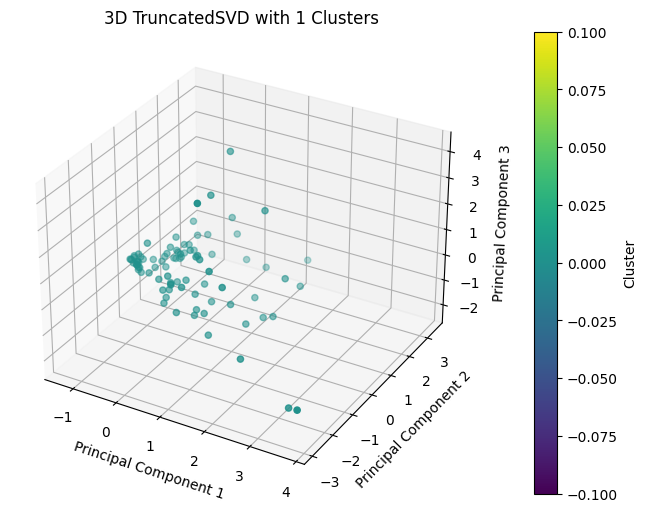

In [62]:
svd = TruncatedSVD(n_components=3)
reduced_features = svd.fit_transform(driver_summary_100810[features])

scaler = StandardScaler()
reduced_features_scaled = scaler.fit_transform(reduced_features)


num_clusters = 1
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)
driver_summary_100810['Cluster'] = kmeans.fit_predict(reduced_features_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(reduced_features_scaled[:, 0], reduced_features_scaled[:, 1], reduced_features_scaled[:, 2],
                    c=driver_summary_100810['Cluster'], cmap='viridis', marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title(f'3D TruncatedSVD with {num_clusters} Clusters')

fig.colorbar(scatter, ax=ax, label='Cluster',pad=0.1)

plt.show()

df_clustered = pd.DataFrame(reduced_features_scaled, columns=['PC1', 'PC2', 'PC3'])
df_clustered['Cluster'] = driver_summary_100810['Cluster']
# print(df_clustered.head())


fig = px.scatter_3d(
    driver_summary_100810, x=reduced_features_scaled[:, 0], y=reduced_features_scaled[:, 1], z=reduced_features_scaled[:, 2],
    color='Cluster',
    labels={'x': 'Principal Component 1', 'y': 'Principal Component 2', 'z': 'Principal Component 3'},
    title=f'Interactive 3D Plot with 5 Clusters'
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [63]:
driver_summary_100810.head()

,trip_uuid,device,absstatus,brakestatus,gpsspeed,speed,longaccel,steerangle,throttlepospct,turnsignal,yawrate,numbsmtx,numcanoutages,numintersectionencounters,numnormalbsmrx,numshadowbsmrx,numspatrx,Cluster
1,004efcf0-a40e-4e94-b96d-322973476dbb,100810,0.0,1628.0,22.821166,21.752625,0.310249,11.893145,6.401485,618,0.930467,16355.0,16.0,0.0,0.0,0.0,3958.0,0
5,00d0e2ac-577d-4786-9932-526bdf2ce15e,100810,1.0,648.0,15.727531,14.707477,0.419792,7.381007,3.858780,384,0.784829,7192.0,14.0,0.0,0.0,0.0,16815.0,0
11,014f3930-9676-430d-830d-056c5d8f29bc,100810,0.0,38.0,22.694144,21.661942,0.330845,1.654545,3.196481,5,0.217656,17130.0,32.0,0.0,0.0,0.0,14532.0,0
19,02dda966-3b6d-488f-9b21-530c41259f6d,100810,0.0,146.0,26.143750,24.998184,0.319794,5.655953,8.157771,92,0.886646,15906.0,22.0,0.0,183.0,0.0,6818.0,0
44,0616dc21-2212-4302-9958-2721455e2895,100810,0.0,25.0,2.818146,2.705000,0.679632,172.763637,0.000000,0,7.216804,1182.0,13.0,0.0,0.0,0.0,0.0,0


In [65]:
driver_summary_100810['brakestatus'].describe()

count      89.000000
mean      531.674157
std       752.226480
min         0.000000
25%        78.000000
50%       230.000000
75%       663.000000
max      3954.000000
Name: brakestatus, dtype: float64

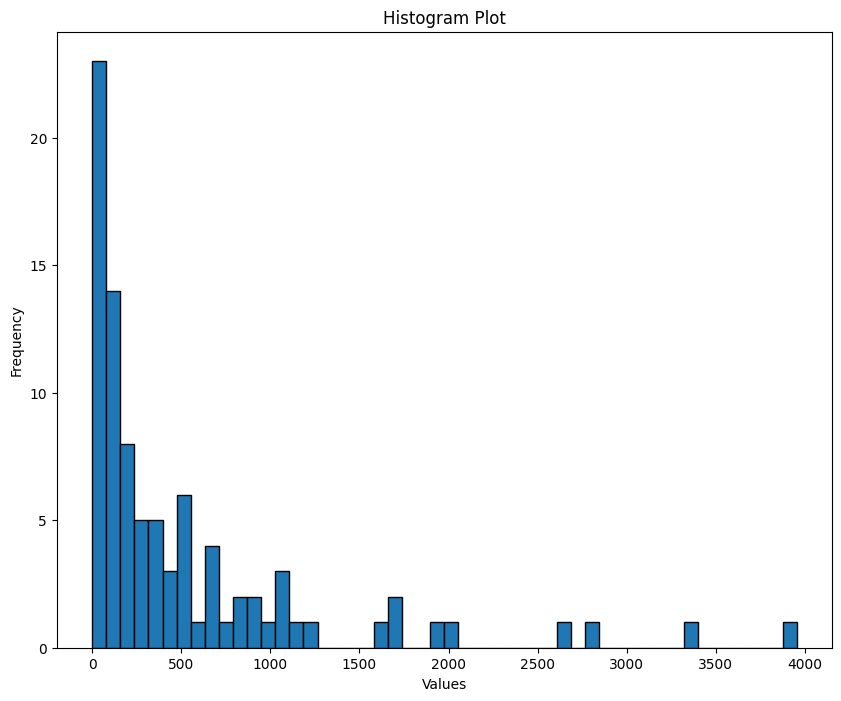

In [78]:
plt.figure(figsize=(10, 8))

driver_summary_100810['brakestatus'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Histogram Plot')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

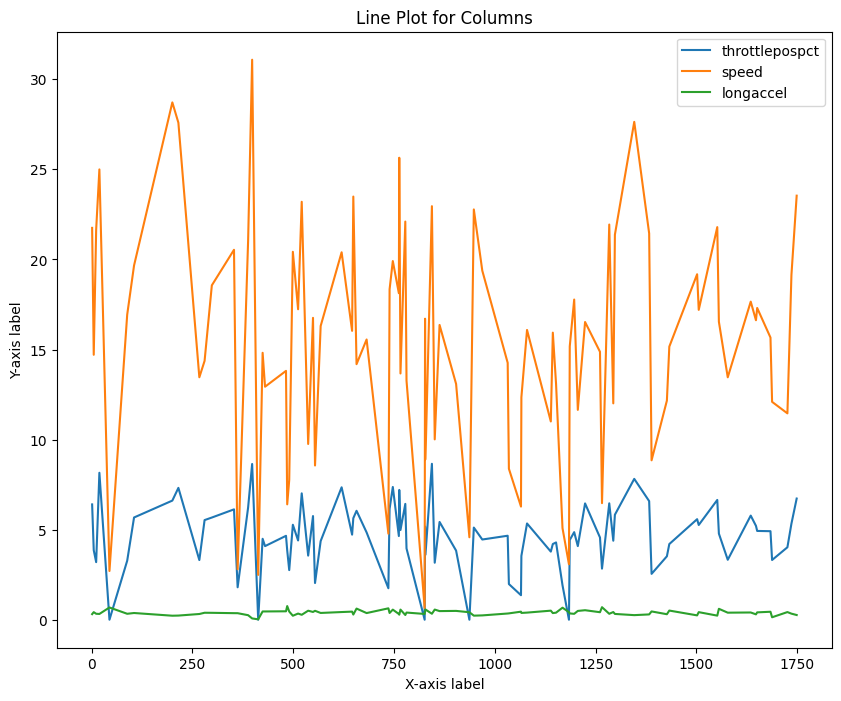

In [79]:
plt.figure(figsize=(10, 8))

plt.plot(driver_summary_100810['throttlepospct'], label='throttlepospct')
plt.plot(driver_summary_100810['speed'], label='speed')
plt.plot(driver_summary_100810['longaccel'], label='longaccel')
# plt.plot(driver_summary_100810['brakestatus'], label='brakestatus')

# Adding labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Line Plot for Columns')

# Adding legend
plt.legend()

# Display the plot
plt.show()

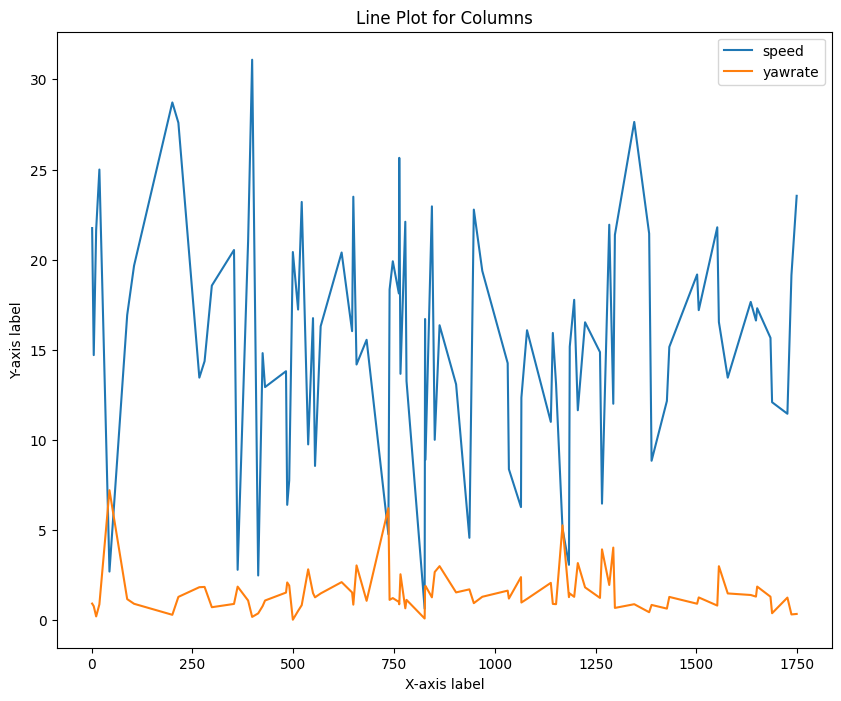

In [77]:
plt.figure(figsize=(10, 8))

# plt.plot(driver_summary_100810['throttlepospct'], label='throttlepospct')
plt.plot(driver_summary_100810['speed'], label='speed')
plt.plot(driver_summary_100810['yawrate'], label='yawrate')
# plt.plot(driver_summary_100810['brakestatus'], label='brakestatus')

# Adding labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Line Plot for Columns')

# Adding legend
plt.legend()

# Display the plot
plt.show()

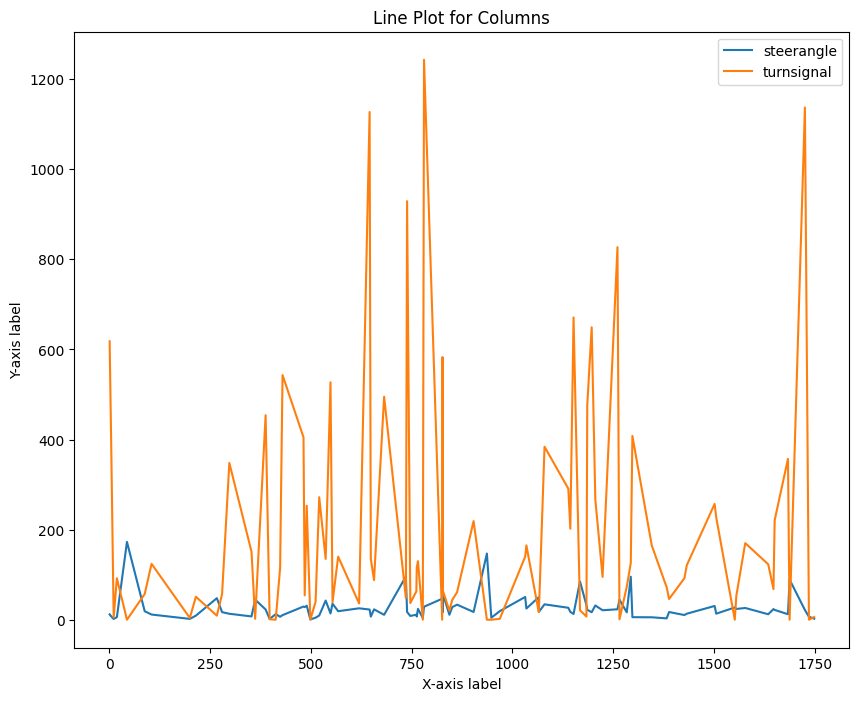

In [80]:
plt.figure(figsize=(10, 8))

# plt.plot(driver_summary_100810['throttlepospct'], label='throttlepospct')
plt.plot(driver_summary_100810['steerangle'], label='steerangle')
plt.plot(driver_summary_100810['turnsignal'], label='turnsignal')
# plt.plot(driver_summary_100810['brakestatus'], label='brakestatus')

# Adding labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Line Plot for Columns')

# Adding legend
plt.legend()

# Display the plot
plt.show()